# 環境構築

In [1]:
# !pip install neologdn
# !pip install emoji


In [2]:
# インポート
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import japanize_matplotlib
import MeCab
from collections import Counter
import neologdn
import emoji
import requests


In [3]:
# mecab-ipadic-NEologdのパスを指定してMeCabを初期化
mecab = MeCab.Tagger('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [4]:
# stopwordsの雛形を作る
# http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt

with open('stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file if line.strip()]


# 前処理

In [5]:
# 空のDataFrameを初期化
combined_df = pd.DataFrame()

# CSVファイルを結合
for year in range(2011, 2014):
    file_name = f"data/r_{year}.csv"
    df_temp = pd.read_csv(
        file_name,
        header=None,
        names=['CD', 'DATE', 'TEXT']
    )
    # 'year'カラムを追加
    df_temp['year'] = year
    # 結合するDataFrameに追加
    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

combined_df


,CD,DATE,TEXT,year
0,2753,20110303,平成23年3月期決算短信〔日本基準〕（連結）平成23年4月4日（百万円未満切捨て）上場会社名...,2011
1,6305,20110304,（百万円未満切捨て）１．平成23年３月期の連結業績（平成22年４月１日～平成23年３月31日...,2011
2,2753,20120303,平成24年3月期第1四半期決算短信〔日本基準〕（連結）平成23年7月4日（百万円未満切捨て）...,2012
3,6305,20120304,（百万円未満四捨五入）１．平成24年３月期の連結業績（平成23年４月１日～平成24年３月31...,2012
4,2753,20130303,平成25年3月期決算短信〔日本基準〕（連結）平成25年4月1日（百万円未満切捨て）上場会社名...,2013
5,6305,20130304,（百万円未満四捨五入）１．平成25年３月期の連結業績（平成24年４月１日～平成25年３月31...,2013


## やるべきこと
- ROA別分析
  - 2年後のROAが上昇している3銘柄の決算短信頻出単語
  - 2年後のROAが下降している3銘柄の決算短信頻出単語
  - ROAが高い/低い業界があるため特徴量に入れるべきことを示唆

In [6]:
# 文字化けを検知
def check_encoding(text):
    try:
        text.encode('utf-8').decode('utf-8')
        return True
    except UnicodeDecodeError:
        return False

combined_df['TEXT'] = combined_df['TEXT'].astype(str)

# 文字化けしている可能性があるエントリの割合を計算
corrupted_percentage = combined_df['TEXT'].apply(lambda x: not check_encoding(x)).mean() * 100

corrupted_percentage


0.0

In [7]:
# 文字化けを解消

combined_df['TEXT'] = combined_df['TEXT'].apply(lambda x: x.encode('sjis', errors='ignore').decode('sjis'))

combined_df


,CD,DATE,TEXT,year
0,2753,20110303,平成23年3月期決算短信〔日本基準〕（連結）平成23年4月4日（百万円未満切捨て）上場会社名...,2011
1,6305,20110304,（百万円未満切捨て）１．平成23年３月期の連結業績（平成22年４月１日平成23年３月31日）...,2011
2,2753,20120303,平成24年3月期第1四半期決算短信〔日本基準〕（連結）平成23年7月4日（百万円未満切捨て）...,2012
3,6305,20120304,（百万円未満四捨五入）１．平成24年３月期の連結業績（平成23年４月１日平成24年３月31日...,2012
4,2753,20130303,平成25年3月期決算短信〔日本基準〕（連結）平成25年4月1日（百万円未満切捨て）上場会社名...,2013
5,6305,20130304,（百万円未満四捨五入）１．平成25年３月期の連結業績（平成24年４月１日平成25年３月31日...,2013


In [8]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', ' ', text) # 数字をスペースに置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


combined_df['TEXT'] = combined_df['TEXT'].apply(preprocess)
combined_df


,CD,DATE,TEXT,year
0,2753,20110303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2011
1,6305,20110304,百万円未満切捨て平成年月期の連結業績平成年月日平成年月日注包括利益年月期百万円年月期百万円参...,2011
2,2753,20120303,平成年月期第四半期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭...,2012
3,6305,20120304,百万円未満四捨五入平成年月期の連結業績平成年月日平成年月日注包括利益年月期百万円年月期百万円...,2012
4,2753,20130303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2013
5,6305,20130304,百万円未満四捨五入平成年月期の連結業績平成年月日平成年月日注包括利益年月期百万円年月期百万円...,2013


In [9]:
# CDが2753のエントリだけを抽出
df_2753 = combined_df[combined_df['CD'] == 2753]
df_2753


,CD,DATE,TEXT,year
0,2753,20110303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2011
2,2753,20120303,平成年月期第四半期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭...,2012
4,2753,20130303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2013


# 文字数

## 平均値をとらない場合

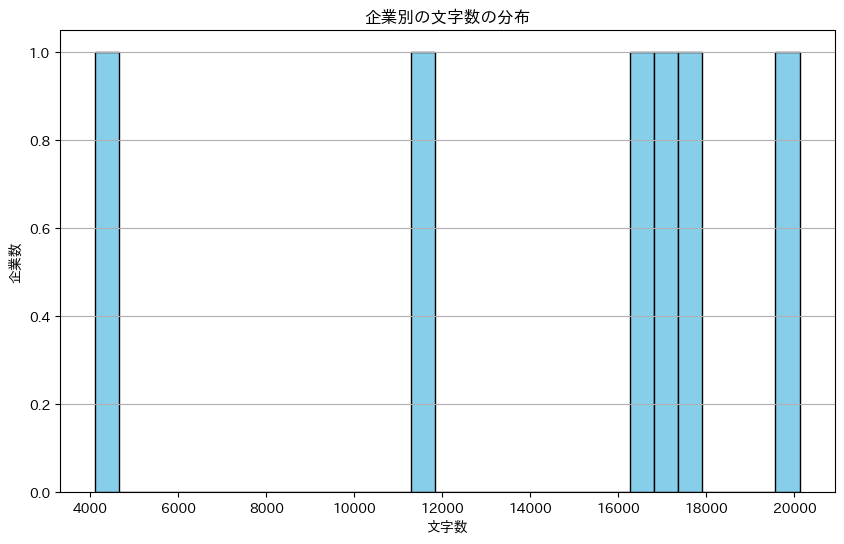

,CD,DATE,TEXT,year,char_count
0,2753,20110303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2011,17763
1,6305,20110304,百万円未満切捨て平成年月期の連結業績平成年月日平成年月日注包括利益年月期百万円年月期百万円参...,2011,20117
2,2753,20120303,平成年月期第四半期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭...,2012,4107
3,6305,20120304,百万円未満四捨五入平成年月期の連結業績平成年月日平成年月日注包括利益年月期百万円年月期百万円...,2012,16656
4,2753,20130303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2013,11678


In [10]:
# Calculate the character count for each text entry
combined_df['char_count'] = combined_df['TEXT'].str.len()

# Determine the range of character counts for the entire dataset
char_count_range = (combined_df['char_count'].min(), combined_df['char_count'].max())

# Create bins for the histogram across the entire range of character counts
bins = np.linspace(char_count_range[0], char_count_range[1], 30)

# Plot the histogram for the character counts
plt.figure(figsize=(10, 6))
plt.hist(combined_df['char_count'].values, bins=bins, color='skyblue', edgecolor='black')
plt.title('企業別の文字数の分布')
plt.xlabel('文字数')
plt.ylabel('企業数')
plt.grid(axis='y')
plt.show()

combined_df.head()


## 平均値を取る場合（補足）

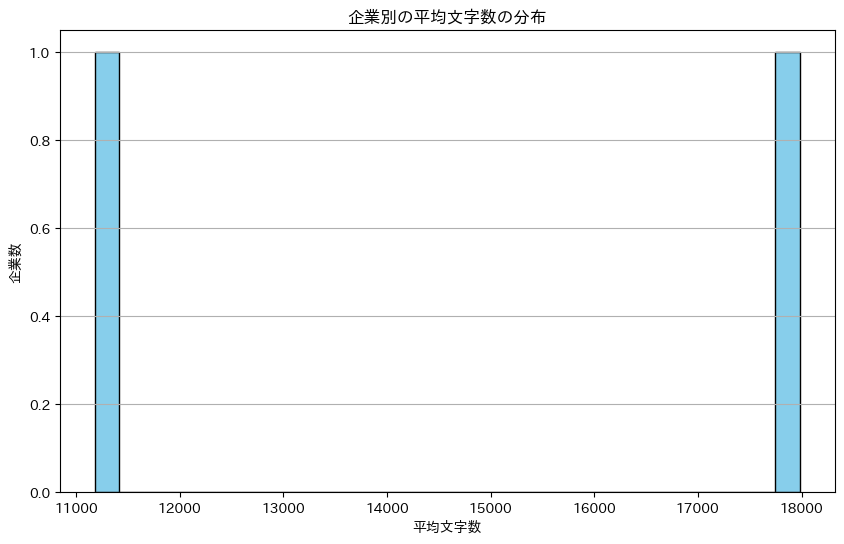

,CD,DATE,TEXT,year,char_count
0,2753,20110303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2011,17763
1,6305,20110304,百万円未満切捨て平成年月期の連結業績平成年月日平成年月日注包括利益年月期百万円年月期百万円参...,2011,20117
2,2753,20120303,平成年月期第四半期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭...,2012,4107
3,6305,20120304,百万円未満四捨五入平成年月期の連結業績平成年月日平成年月日注包括利益年月期百万円年月期百万円...,2012,16656
4,2753,20130303,平成年月期決算短信日本基準連結平成年月日百万円未満切捨て上場会社名株式会社あみやき亭上場取引...,2013,11678


In [11]:
# 文字数を計算
combined_df['char_count'] = combined_df['TEXT'].str.len()

# 企業ごとの平均文字数を計算
average_char_count_by_company = combined_df.groupby('CD')['char_count'].mean()

# 文字数の範囲を決める
char_count_range = (average_char_count_by_company.min(), average_char_count_by_company.max())

# ヒストグラムのビンを作成
bins = np.linspace(char_count_range[0], char_count_range[1], 30)

# プロット
plt.figure(figsize=(10, 6))
plt.hist(average_char_count_by_company.values, bins=bins, color='skyblue', edgecolor='black')
plt.title('企業別の平均文字数の分布')
plt.xlabel('平均文字数')
plt.ylabel('企業数')
plt.grid(axis='y')
plt.show()

combined_df.head()


# 単語数

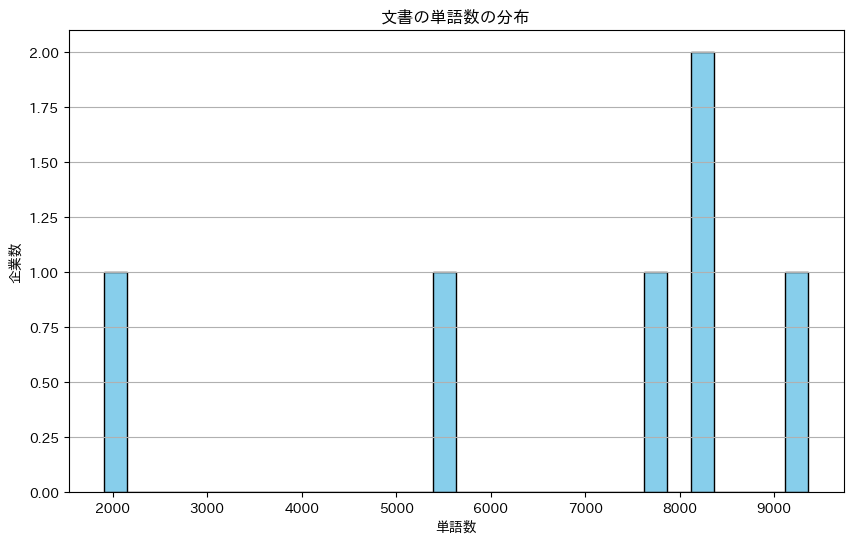

In [12]:
# 単語数の分布

# 単語数カウント関数（上述の関数と同様）
def count_words(text):
    mecab.parse('')  # 空文字列をparseすることで、文字列が初期化されるバグを回避
    node = mecab.parseToNode(text)
    count = 0
    while node:
        if node.feature.split(',')[0] != 'BOS/EOS':
            count += 1
        node = node.next
    return count

# テキストのDataFrameに単語数カラムを追加
combined_df['word_count'] = combined_df['TEXT'].apply(count_words)

# 単語数の分布をヒストグラムで可視化
plt.figure(figsize=(10, 6))
plt.hist(combined_df['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('文書の単語数の分布')
plt.xlabel('単語数')
plt.ylabel('企業数')
plt.grid(axis='y')
plt.show()

# 単語数が極端に少ない/多いデータが存在するので欠損値や外れ値の前処理が必要


# 名詞の出現回数

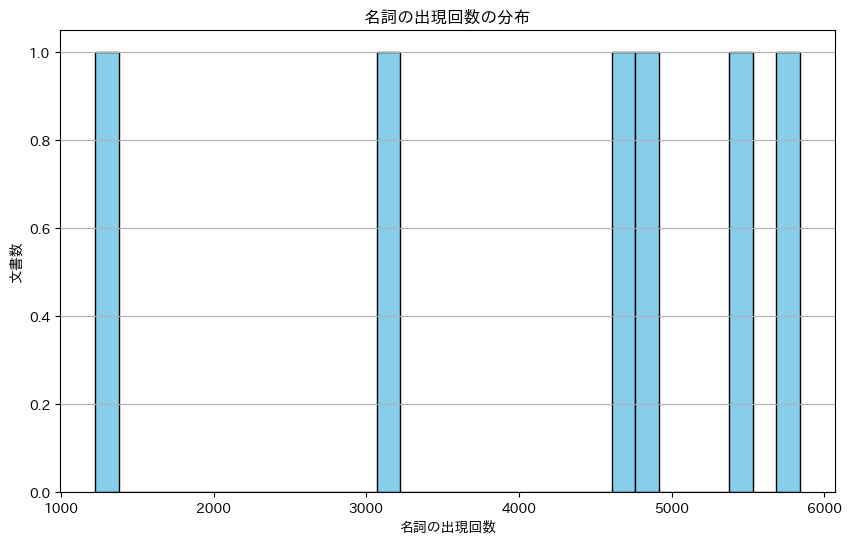

In [13]:
# 名詞のみをカウントする関数
def count_nouns(text):
    mecab.parse('')  # 空文字列をparseすることで、文字列が初期化されるバグを回避
    node = mecab.parseToNode(text)
    count = 0
    while node:
        # 品詞情報が名詞に関連するものであればカウントを増やす
        if node.feature.split(',')[0] == '名詞':
            count += 1
        node = node.next
    return count

# DataFrame内の各テキストに対して名詞のカウントを実行
combined_df['noun_count'] = combined_df['TEXT'].apply(count_nouns)

# 名詞の出現回数の分布をプロット
plt.figure(figsize=(10, 6))
plt.hist(combined_df['noun_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('名詞の出現回数の分布')
plt.xlabel('名詞の出現回数')
plt.ylabel('文書数')
plt.grid(axis='y')
plt.show()


# 動詞の出現回数

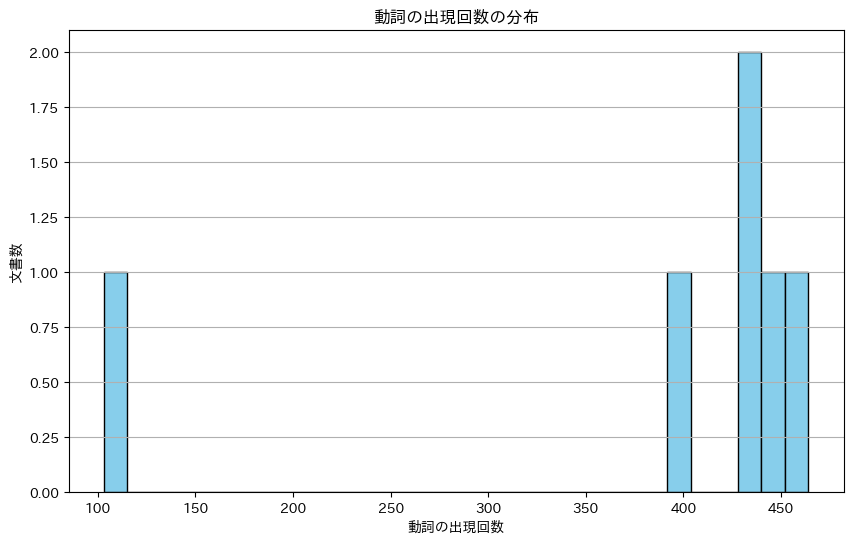

In [14]:
# 動詞のみをカウントする関数
def count_verbs(text):
    mecab.parse('')  # 空文字列をparseすることで、バグを回避
    node = mecab.parseToNode(text)
    count = 0
    while node:
        # 品詞情報が動詞に関連するものであればカウントを増やす
        if node.feature.split(',')[0] == '動詞':
            count += 1
        node = node.next
    return count

# DataFrame内の各テキストに対して動詞のカウントを実行
combined_df['verb_count'] = combined_df['TEXT'].apply(count_verbs)

# 動詞の出現回数の分布をプロット
plt.figure(figsize=(10, 6))
plt.hist(combined_df['verb_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('動詞の出現回数の分布')
plt.xlabel('動詞の出現回数')
plt.ylabel('文書数')
plt.grid(axis='y')
plt.show()


# 形容詞の出現回数

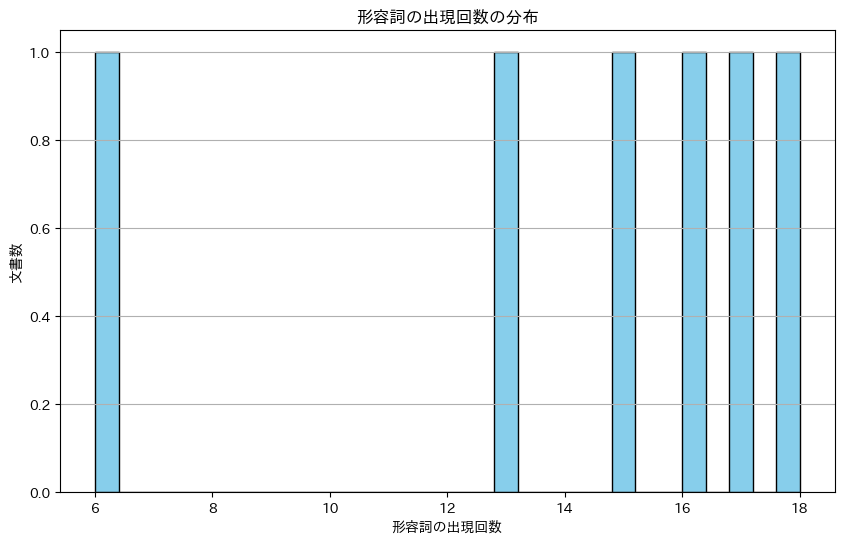

In [15]:
# 形容詞のみをカウントする関数
def count_adjectives(text):
    mecab.parse('')  # 空文字列をparseすることで、バグを回避
    node = mecab.parseToNode(text)
    count = 0
    while node:
        # 品詞情報が形容詞に関連するものであればカウントを増やす
        if node.feature.split(',')[0] == '形容詞':
            count += 1
        node = node.next
    return count

# DataFrame内の各テキストに対して形容詞のカウントを実行
combined_df['adjective_count'] = combined_df['TEXT'].apply(count_adjectives)

# 形容詞の出現回数の分布をプロット
plt.figure(figsize=(10, 6))
plt.hist(combined_df['adjective_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('形容詞の出現回数の分布')
plt.xlabel('形容詞の出現回数')
plt.ylabel('文書数')
plt.grid(axis='y')
plt.show()


# 出現頻度の高い単語のリストアップ

In [16]:
# コーパス全体の単語をカウントする関数
def count_words(text):
    mecab.parse('')  # 空文字列をparseすることで、バグを回避
    node = mecab.parseToNode(text)
    words = []
    while node:
        if node.feature.split(',')[0] in ['名詞', '動詞', '形容詞']:
            words.append(node.surface)
        node = node.next
    return words

# コーパス全体から単語をカウント
word_list = []
for text in combined_df['TEXT']:
    word_list.extend(count_words(text))

# 単語の出現回数をカウント
word_counts = Counter(word_list)

# 最も頻出する単語をリストアップ（例：上位30語）
most_common_words = word_counts.most_common(30)

# ストップワードの辞書を作成（単語と出現回数）
stopwords_with_counts = {word: count for word, count in most_common_words}

stopwords_with_counts


{'年月日': 456,
 '額': 449,
 '平成': 402,
 '円': 380,
 '期': 346,
 'おり': 314,
 '合計': 312,
 '連結': 295,
 '年月': 292,
 '連結会計': 280,
 '百': 270,
 '年度': 269,
 '万': 268,
 '百万円': 262,
 '等': 244,
 'その他': 230,
 '当期': 224,
 'する': 223,
 '変動': 216,
 '事業': 214,
 'グループ': 181,
 '残高': 173,
 '株': 163,
 '億': 162,
 '当期純利益': 152,
 '売上高': 151,
 '至': 147,
 '決算短信': 131,
 '当社': 131,
 '固定資産': 124}

In [17]:
stopwords.extend([word for word, count in most_common_words])
stopwords


['あそこ',
 'あたり',
 'あちら',
 'あっち',
 'あと',
 'あな',
 'あなた',
 'あれ',
 'いくつ',
 'いつ',
 'いま',
 'いや',
 'いろいろ',
 'うち',
 'おおまか',
 'おまえ',
 'おれ',
 'がい',
 'かく',
 'かたち',
 'かやの',
 'から',
 'がら',
 'きた',
 'くせ',
 'ここ',
 'こっち',
 'こと',
 'ごと',
 'こちら',
 'ごっちゃ',
 'これ',
 'これら',
 'ごろ',
 'さまざま',
 'さらい',
 'さん',
 'しかた',
 'しよう',
 'すか',
 'ずつ',
 'すね',
 'すべて',
 'ぜんぶ',
 'そう',
 'そこ',
 'そちら',
 'そっち',
 'そで',
 'それ',
 'それぞれ',
 'それなり',
 'たくさん',
 'たち',
 'たび',
 'ため',
 'だめ',
 'ちゃ',
 'ちゃん',
 'てん',
 'とおり',
 'とき',
 'どこ',
 'どこか',
 'ところ',
 'どちら',
 'どっか',
 'どっち',
 'どれ',
 'なか',
 'なかば',
 'なに',
 'など',
 'なん',
 'はじめ',
 'はず',
 'はるか',
 'ひと',
 'ひとつ',
 'ふく',
 'ぶり',
 'べつ',
 'へん',
 'ぺん',
 'ほう',
 'ほか',
 'まさ',
 'まし',
 'まとも',
 'まま',
 'みたい',
 'みつ',
 'みなさん',
 'みんな',
 'もと',
 'もの',
 'もん',
 'やつ',
 'よう',
 'よそ',
 'わけ',
 'わたし',
 'ハイ',
 '上',
 '中',
 '下',
 '字',
 '年',
 '月',
 '日',
 '時',
 '分',
 '秒',
 '週',
 '火',
 '水',
 '木',
 '金',
 '土',
 '国',
 '都',
 '道',
 '府',
 '県',
 '市',
 '区',
 '町',
 '村',
 '各',
 '第',
 '方',
 '何',
 '的',
 '度',
 '文',
 '者',
 '性',
 '体',
 '人',
 '他',
 '今',
 

# n-gram

In [18]:
# N-gram出現回数
# uni-gram
# bi-gram
# tri-gram
